In [1]:
%matplotlib inline

import numpy as np
import sys
import math
import os
import time
import matplotlib.pyplot as plt
import seaborn

In [2]:

"""
Generate publication figures.

* Water presence/absence
* Fig 3B: Unnormalized autocorrelation functions for WT +/- Tpx2
* Fig 3C: Slow component of autocorrelation times and populations for mutants
* alphaC helix RMSD

"""

#hbond_basepath = '/cbio/jclab/projects/behrj/AURKA_UMN/'
hbond_basepath = 'data' # location of extracted trajectory features
output_basepath = 'figures'

if not os.path.exists(output_basepath):
    os.makedirs(output_basepath)

# Parameters
nclones = 50 # number of CLONEs per RUN
projects = ['11414', '11419', '11418', '11423']
nruns = 7 # number of runs per project
resid = 185 # residue number used in constructing paths

# location of simulation data for each mutant
simulations = {
    '+Tpx2 WT' : [('11414', 'RUN0'), ('11419', 'RUN0'), ('11419', 'RUN1'), ('11419', 'RUN2'), ('11419', 'RUN3')],
    '+Tpx2 Q185C' : [('11414', 'RUN1')],
    '+Tpx2 Q185L' : [('11419', 'RUN2')],
    '-Tpx2 WT' : [('11418', 'RUN0'), ('11418', 'RUN1'), ('11418', 'RUN2'), ('11418', 'RUN3'), ('11418', 'RUN4')],
    '-Tpx2 Q185C' : [('11423', 'RUN0')],
    '-Tpx2 Q185L' : [('11423', 'RUN1')],
}

def squeeze_empty_trajectories(W):
    """
    Squeeze empty trajectories that are [None, ..., None] out from water set trajectories for W1 or W2.

    Parameters
    ----------
    W : np.array of dimension (ntraj, nframes)
        The trajectory to squeeze.

    Returns
    -------
    Wsqueezed : np.array of dimension (ntraj_squeezed, nframes)
        Squeezed version of W
    """
    non_empty_trajectories = list()
    for traj in range(W.shape[0]):
        if not np.all(np.equal(W[traj,:],  None)):
            non_empty_trajectories.append(traj)
    Wsqueezed = W[non_empty_trajectories,:]
    print('Squeezed out %d empty trajectories' % (W.shape[0] - Wsqueezed.shape[0]))
    return Wsqueezed

def retrieve_data(key):
    """
    Compile all available W1, W2 water set data for the specified simulation into a single array.

    Parameters
    ----------
    key : str
        The key into 'simulations' to identify projects and RUNs associated with the simulation data.

    Returns
    -------
    W1 : np.array shape (nsim, nsamples)
        Water 1 sets
    W2 : np.array shape (nsim, nsamples)
        Water 2 sets
    """
    print("Retrieving data for '%s'..." % key)
    [W1, W2] = [list(), list()]
    for (project,run) in simulations[key]:
        W1.append( np.load(os.path.join(hbond_basepath, 'output-%(project)s/data/%(run)s-274N-oxygen-indices.npy' % vars())) )
        W2.append( np.load(os.path.join(hbond_basepath, 'output-%(project)s/data/%(run)s-W2-181185-or275-oxygen-indices.npy' % vars())) )
    [W1, W2] = [np.vstack(W1), np.vstack(W2)]
    # Squeeze out rows that are just None
    [W1, W2] = [squeeze_empty_trajectories(W1), squeeze_empty_trajectories(W2)]
    return [W1, W2]

In [3]:
# Constuct binary arrays
def water_occupation_array(W):
    """
    Return an array that has a value of +1 if a water is present in that frame, 0 if not, -1 if no data due to truncated simulation.
    
    Parameters
    ----------
    W : np.array with shape (ntrajs,nframes)
        The water set trajectory
        
    Returns
    -------
    X : np.array with shape (ntrajs,nframes) dtype=np.float32
        X[traj,frame] = 1 if at least one water is present at the water site
                      = 0 if no water is present
                      = -1 if no simulation data available
    """
    X = np.zeros(W.shape, np.float32)
    [ntraj, nframe] = W.shape
    for traj in range(ntraj):
        for frame in range(nframe):
            if (W[traj,frame] is None):
                X[traj,frame] = -1
            elif (len(W[traj,frame]) > 0):
                X[traj,frame] = 1
    return X

In [15]:
def plot_water_occupancies(key, figsize=[20, 4.]):
    """
    Plot water occupancies for the specified key.
    
    Blue (-1) denotes no data; white (0) denotes no water; red (+1) denotes one or more waters present.
    
    Parameters
    ----------
    key : str
        The simulation key ['-Tpx2 WT', '+Tpx2 WT', '-Tpx2 Q185C', ...]
    figsize : list of len 2, optional
        The figure size to generate
            
    """

    # Retrieve data
    [W1, W2] = retrieve_data(key)

    fig = plt.figure(figsize=figsize)

    [ntrajs, nframes] = W1.shape
    
    plt.subplot(1,2,1);
    X1 = water_occupation_array(W1)
    plt.title('%s W1' % key);
    cax = plt.imshow(X1, extent=[0, nframes/4., 0, ntrajs], aspect='auto', cmap=plt.get_cmap('bwr'))
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    plt.xlabel('time / ns');
    plt.ylabel('trajectory');

    plt.subplot(1,2,2);
    X2 = water_occupation_array(W2)
    plt.title('%s W2' % key);
    cax = plt.imshow(X2, extent=[0, nframes/4., 0, ntrajs], aspect='auto', cmap=plt.get_cmap('bwr'))
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    plt.xlabel('time / ns');
    plt.ylabel('trajectory');

Retrieving data for '-Tpx2 WT'...
Squeezed out 1000 empty trajectories
Squeezed out 1000 empty trajectories
Retrieving data for '+Tpx2 WT'...
Squeezed out 1000 empty trajectories
Squeezed out 1000 empty trajectories


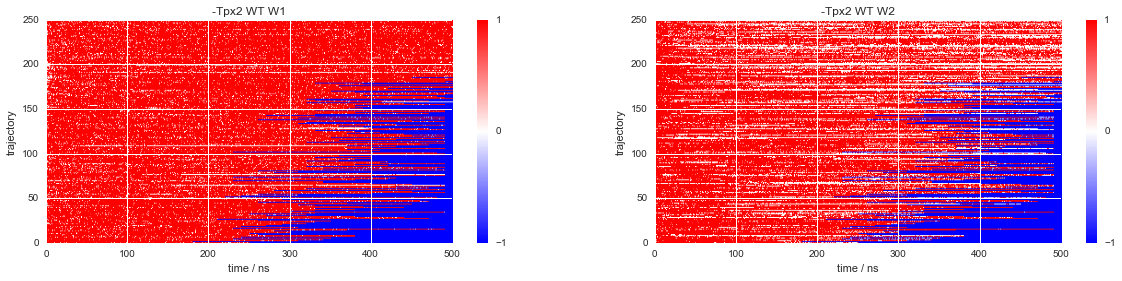

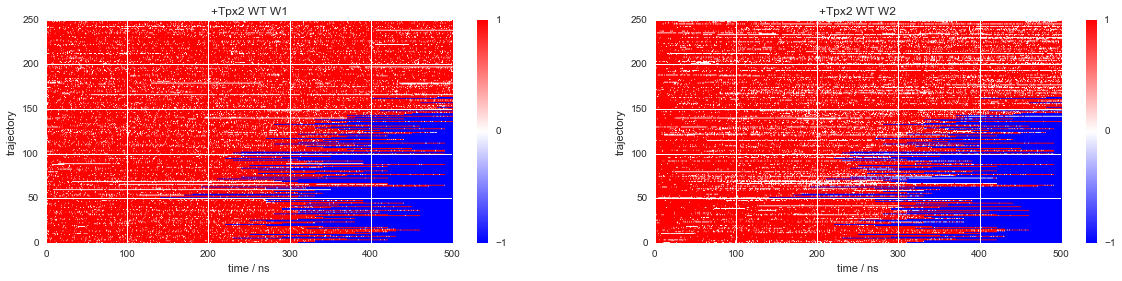

In [16]:
plot_water_occupancies('-Tpx2 WT')
plot_water_occupancies('+Tpx2 WT')

Retrieving data for '-Tpx2 Q185C'...
Squeezed out 200 empty trajectories
Squeezed out 200 empty trajectories
Retrieving data for '+Tpx2 Q185C'...
Squeezed out 200 empty trajectories
Squeezed out 200 empty trajectories


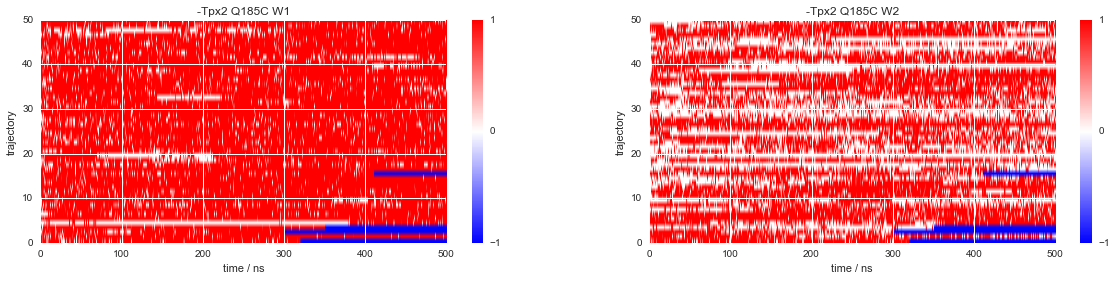

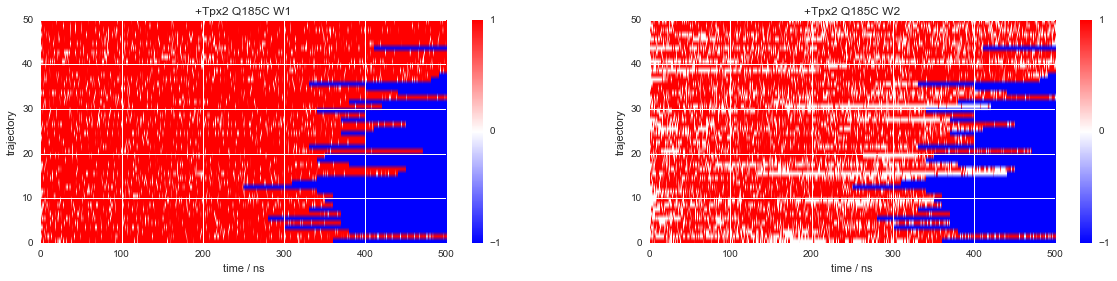

In [17]:
plot_water_occupancies('-Tpx2 Q185C')
plot_water_occupancies('+Tpx2 Q185C')

Retrieving data for '-Tpx2 Q185L'...
Squeezed out 200 empty trajectories
Squeezed out 200 empty trajectories
Retrieving data for '+Tpx2 Q185L'...
Squeezed out 200 empty trajectories
Squeezed out 200 empty trajectories


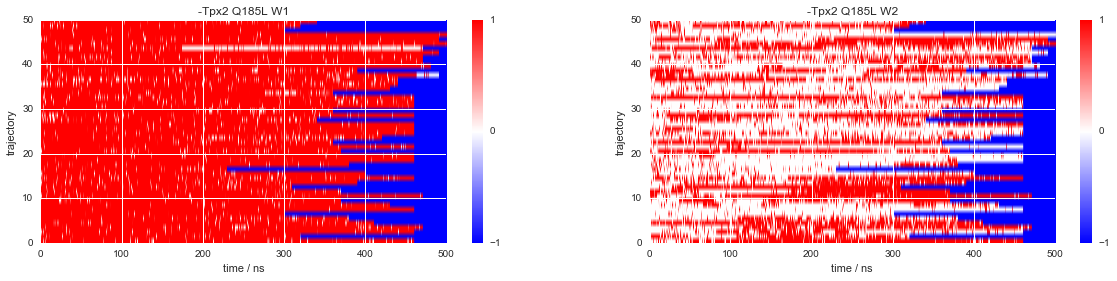

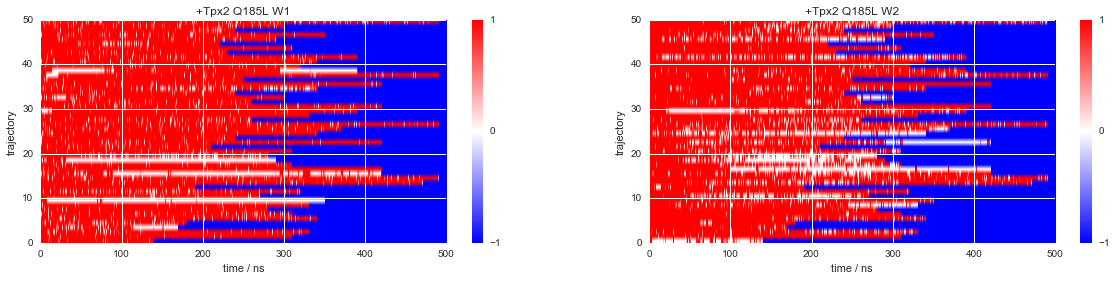

In [18]:
plot_water_occupancies('-Tpx2 Q185L')
plot_water_occupancies('+Tpx2 Q185L')

In [60]:
ns_per_frame = 0.250 # nanoseconds per frame

def correlation_function_contributions(W, tmax=300):
    """
    Compute unnormalized correlation function contributions from each trajectory.
    
    Unnormalized correlation function:
        C(0) indicates water population at specified site
        C(tau) indicates same water at time 0 and time tau    

    Parameters
    ----------
    W : numpy.array shape (ntrajs,nframes)
        W[traj,frame] is the set of water oxygen indices present in the specified site at 'frame' of trajectory 'traj
    tmax : int, optional, default=250
        Maximum number of frames to compute correlation function for
 
    Returns
    -------
    C : np.array with shape (ntrajs,tmax+1)
        C[traj,tau] is the unnormalized correlation function contribution from trajectory 'traj'
        Averaging over all trajectories will give the MLE, but this can also be bootstrapped to get uncertainties
        and confidence intervals.

    """
    [ntrajs, nframes] = W.shape
    C = np.zeros([ntrajs,tmax+1], np.float64)
    for traj in range(ntrajs):   
        Wtraj = W[traj,:]
        nframes = np.sum(np.not_equal(Wtraj, None))
        for t in range(tmax+1):
            for t0 in range(nframes-t):
                same_waters = (len(Wtraj[t0].intersection(Wtraj[t0+t]))>0)
                C[traj,t] += same_waters / np.float(nframes-t)
    return C

def fit_correlation_function_tail(C, tmin):
    """
    Fit the tail of the correlation function.

    Parameters
    ----------
    C : np.array with shape (tmax+1,)
        C[tau] is the MLE for the unnormalized correlation function
    tmin : int
        Minimum time (in frames) to start curve fitting

    Returns
    -------
    P : float
        Population of long-lived waters
    tau : float
        Autocorrelation timescale for long-lived waters
    Cfit : np.array with shape (tmax+1,)
        Cfit[tau] is the fit of the correlation function tail

    """
    # Determine maximum time for correlation function
    tmax = C.shape[0] - 1 
    
    tvec = np.arange(tmax+1) * ns_per_frame # time vector (ns)
    tvec_indices = range(tmin,tmax+1)
    
    # Fit the correlation function tail
    from scipy.optimize import curve_fit
    def Cmodel(tvec, P, tau):
        return P*np.exp(-tvec/tau)
    
    popt, pcov = curve_fit(Cmodel, tvec[tvec_indices], C[tvec_indices], p0=[0.2, 50])    
    
    # Extract solution
    P = popt[0]
    tau = popt[1]
    
    # Compute fit
    Cfit = Cmodel(tvec, P, tau)

    return [P, tau, Cfit]

def sample_ci(data, interval=0.95):
    """
    Estimate confidence interval from a bootstrapped sample.
    
    Parameters
    ----------
    data : np.array of shape (nbootstrap,)
        The bootstrapped sample
    interval : float, optional, default=0.95
        The confidence interval size to compute
        
    Returns
    -------
    low_val, high_val : float
        The low and high confidence inverval estimates
        
    """
    import scipy as sp
    import scipy.stats

    sorted = np.sort(data)
    ndata = len(data)
    ilow = int(np.round((0.5-interval/2.)*ndata))
    ihigh = int(np.round((0.5+interval/2.)*ndata))
    ilow = min(ndata-1, ilow) # ensure within data range
    ihigh = min(ndata-1, ihigh) # ensure within data range
    return [sorted[ilow], sorted[ihigh]]

def correlation_function_statistics(C, ci=0.95, tmin=60, nbootstrap=10):
    """
    Compute unnormalized corelation function MLE and bootstrapped estimates.

    Parameters
    ----------
    C : np.array with shape (ntrajs,tmax+1)
        C[traj,tau] is the unnormalized correlation function contribution from trajectory 'traj'
        Averaging over all trajectories will give the MLE, but this can also be bootstrapped to get uncertainties
        and confidence intervals.
    ci : float, optional, default=0.95
        Size of confidence interval for bootstrapping
    tmin : int
        Minimum time (in frames) to start curve fitting
    nbootstrap : int
        Number of bootstrap samples to generate
        
    Returns
    -------
    tvec : np.array with shape (tmax+1,)
        time vector to accompany correlation functions
    C_mle : np.array with shape (tmax+1,)
        C[tau] is the MLE for the unnormalized correlation function
    C_low, C_high : np.array with shape (tmax+1,)
        Bootstrapped confidence interval for C(t) using confidence interval 'ci'
    Cfit_mle : np.array with shape (tmax+1,)
        Fit to correlation function tail for C_mle
    P_mle : float
        MLE estimate of population of long-lived water
    P_low, P_high : float
        Bootstrapped confidence interval for population of long-lived water
    tau_mle : float
        MLE estimate of slow decay timescale
    tau_low, tau_high : float
        Bootstrapped confidence interval for relaxation timescale of long-lived water population
    """
    ntrajs = C.shape[0]
    tmax = C.shape[1] - 1
    tvec = np.arange(tmax+1) * ns_per_frame # time vector (ns)
    
    # Compute maximum-likelihood estimators
    C_mle = C.mean(0)
    [P_mle, tau_mle, Cfit_mle] = fit_correlation_function_tail(C_mle, tmin=tmin)
    
    # Bootstrap
    C_n = np.zeros([nbootstrap, tmax+1], np.float32)
    P_n = np.zeros([nbootstrap], np.float64)
    tau_n = np.zeros([nbootstrap], np.float64)
    for bootstrap in range(nbootstrap):
        # Sample trajectories with replacement
        traj_indices = np.random.choice(range(ntrajs), size=ntrajs, replace=True)
        # Compute correlation function estimate
        C_replicate = C[traj_indices,:].mean(0)
        # Exponential fit to tail
        [P, tau, Cfit] = fit_correlation_function_tail(C_replicate, tmin=tmin)
        # Store
        C_n[bootstrap,:] = C_replicate
        P_n[bootstrap] = P
        tau_n[bootstrap] = tau

    # Compute statistics
    [P_low, P_high] = sample_ci(P_n, interval=ci)
    [tau_low, tau_high] = sample_ci(tau_n, interval=ci)
    C_low = 0.0 * C_mle
    C_high = 0.0 * C_mle    
    for tau in range(tmax+1):
        [C_low[tau], C_high[tau]] = sample_ci(C_n[:,tau], interval=ci)
        
    return [tvec, C_mle, Cfit_mle, C_low, C_high, P_mle, P_low, P_high, tau_mle, tau_low, tau_high]

In [61]:
# Retrieve data
key = '-Tpx2 WT'
[W1, W2] = retrieve_data(key)

# Compute per-trajectory correlation function contributions
tmax = 300 # 75 ns
C1 = correlation_function_contributions(W1, tmax=tmax)
C2 = correlation_function_contributions(W2, tmax=tmax)

Retrieving data for '-Tpx2 WT'...
Squeezed out 1000 empty trajectories
Squeezed out 1000 empty trajectories


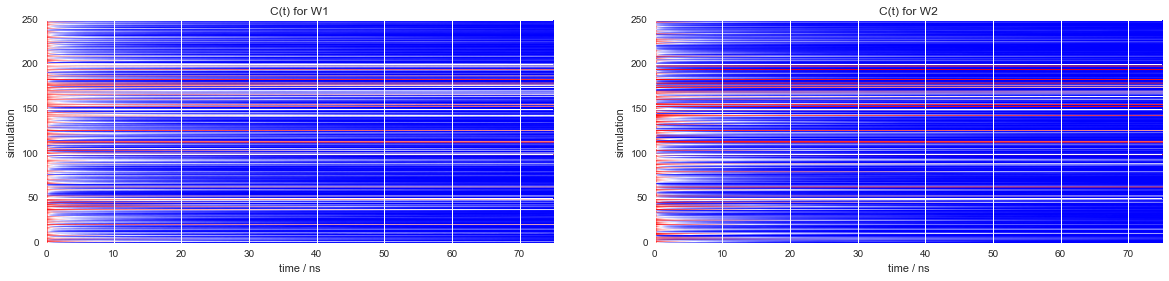

In [62]:
# Plot trajectory contributions to correlation functions
fig = plt.figure(figsize=[20, 4.])

ntrajs = C2.shape[0]
tmax = C1.shape[1] - 1
tvec = np.arange(tmax+1) * ns_per_frame # time vector (ns)

plt.subplot(1,2,1);
plt.title('C(t) for W1');
cax = plt.imshow(C1, extent=[0, tmax/4., 0, ntrajs], aspect='auto', cmap=plt.get_cmap('bwr'))
#cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
plt.xlabel('time / ns');
plt.ylabel('simulation');

plt.subplot(1,2,2);
plt.title('C(t) for W2');
cax = plt.imshow(C2, extent=[0, tmax/4., 0, ntrajs], aspect='auto', cmap=plt.get_cmap('bwr'))
#cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
plt.xlabel('time / ns');
plt.ylabel('simulation');

In [63]:
[tvec, C_mle, Cfit_mle, C_low, C_high, P_mle, P_low, P_high, tau_mle, tau_low, tau_high] = correlation_function_statistics(C1, ci=0.95, tmin=60, nbootstrap=10)

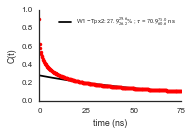

In [122]:
import seaborn as sns
sns.set_style("white")

# Match sans serif text in LaTeX number rendering
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

# Plot MLE correlation function and exponential fit
wat = 'W1 -Tpx2'
fontsize = 6
fig = plt.figure(figsize=[2.75,2])
plt.hold(True)
h = plt.plot(tvec, Cfit_mle, 'k-')
plt.plot(tvec, C_mle, 'r.')
plt.axis([0, tvec[-1], 0, 1]);
plt.xlabel('time (ns)');
plt.ylabel('C(t)');
plt.xticks([0, 25, 50, 75])
plt.legend(['%s: ${%.1f}_{%.1f}^{%.1f}$%% ; $\\tau$ = ${%.1f}_{%.1f}^{%.1f}$ ns' % (wat, P_mle*100, P_low*100, P_high*100, tau_mle, tau_low, tau_high)], fontsize=fontsize);
sns.despine()
plt.tight_layout()
plt.savefig('Fig-3B.pdf')